In [12]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [13]:
data_hor_disc = pd.read_excel("Data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
# data_hor_cont = pd.read_excel("Data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
# data_ver_disc = pd.read_excel("Data/DiscreteMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
# data_ver_cont = pd.read_excel("Data/ContinuousMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")

In [14]:
data_hor_disc.head(5)

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
0,0.846,0.044,0.014,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
1,0.846,0.044,0.167,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
2,0.846,0.044,0.167,0.255,4.009,5.676,5.400,6.930,9.240,9.974999,9.728000,6.578000,11.834999,7.830,12.599,9.990001,10.465000,13.454000,11.039999,0.564
3,0.774,0.147,0.167,4.080,4.199,5.676,5.400,6.930,7.854,8.014999,9.728000,6.578000,11.834999,7.830,7.267,9.287000,10.465000,13.454000,11.039999,0.564
4,0.774,0.147,2.171,4.080,4.199,5.676,5.400,6.468,7.854,8.014999,9.472000,10.372999,11.834999,12.267,7.267,9.287000,15.548001,13.454000,11.280000,10.434


In [15]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor_disc.columns]
scaler = MinMaxScaler()

perc=0.7


# Splitting the dataset into train and test --> 70% in length is used for train
df_train=data_hor_disc.head(int(len(data_hor_disc)*perc))
df_test=data_hor_disc.head(int(len(data_hor_disc)*(1-perc)))

scaled_train = scaler.fit_transform(df_train[power_list])
scaled_test = scaler.transform(df_test[power_list])

In [16]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [17]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [18]:
LOOK_BACK=500
FORECAST_RANGE=1
n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30999, 500, 20)
(30999, 1, 20)
(13000, 500, 20)
(13000, 1, 20)


In [19]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [20]:
epochs = 50
batch_size = 32
validation = 0.1

In [21]:
checkpoint_filepath = 'improvementsModel/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.005)

In [22]:
## Encoder-Decoder Model

model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='tanh', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/50
872/872 [==============================] - 190s 214ms/step - loss: 0.0185 - val_loss: 0.0081 - lr: 0.0010
Epoch 2/50
872/872 [==============================] - 164s 188ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/50
872/872 [==============================] - 3002s 3s/step - loss: 0.0080 - val_loss: 0.0078 - lr: 0.0010
Epoch 4/50
872/872 [==============================] - 2025s 2s/step - loss: 0.0079 - val_loss: 0.0076 - lr: 0.0010
Epoch 5/50
872/872 [==============================] - 2889s 3s/step - loss: 0.0078 - val_loss: 0.0075 - lr: 0.0010
Epoch 6/50
872/872 [==============================] - 2087s 2s/step - loss: 0.0077 - val_loss: 0.0075 - lr: 0.0010
Epoch 7/50
872/872 [==============================] - 2993s 3s/step - loss: 0.0077 - val_loss: 0.0074 - lr: 0.0010
Epoch 8/50
872/872 [======================

In [23]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='tanh', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='tanh')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

In [24]:
## Vector Output Model

input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv)
lstm = LSTM(100, return_sequences=True, activation='tanh')(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100, activation='tanh')(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='tanh')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

In [25]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='tanh')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

Text(0, 0.5, 'MAPE')

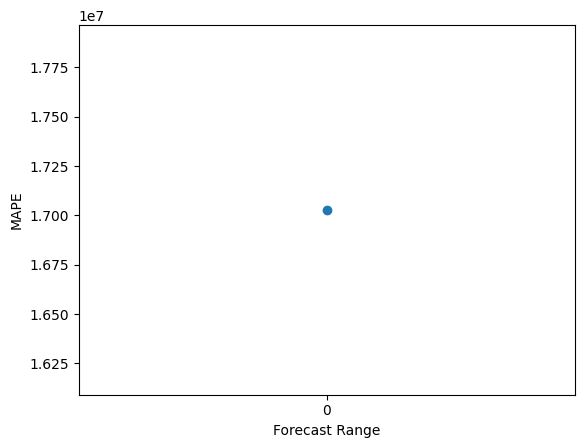

In [27]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

In [28]:
for i in range(0, n_features):
    print('->', i)
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0
mae: tf.Tensor(0.029950965, shape=(), dtype=float32)
mse: tf.Tensor(0.00424189, shape=(), dtype=float32)
mape: tf.Tensor(526089.9, shape=(), dtype=float32)
-> 1
mae: tf.Tensor(0.06918168, shape=(), dtype=float32)
mse: tf.Tensor(0.022993905, shape=(), dtype=float32)
mape: tf.Tensor(3379147.8, shape=(), dtype=float32)
-> 2
mae: tf.Tensor(0.0978364, shape=(), dtype=float32)
mse: tf.Tensor(0.054375585, shape=(), dtype=float32)
mape: tf.Tensor(4526972.0, shape=(), dtype=float32)
-> 3
mae: tf.Tensor(0.13656276, shape=(), dtype=float32)
mse: tf.Tensor(0.118441746, shape=(), dtype=float32)
mape: tf.Tensor(5009908.0, shape=(), dtype=float32)
-> 4
mae: tf.Tensor(0.17824602, shape=(), dtype=float32)
mse: tf.Tensor(0.191793, shape=(), dtype=float32)
mape: tf.Tensor(6206362.5, shape=(), dtype=float32)
-> 5
mae: tf.Tensor(0.23722965, shape=(), dtype=float32)
mse: tf.Tensor(0.33431405, shape=(), dtype=float32)
mape: tf.Tensor(12595362.0, shape=(), dtype=float32)
-> 6
mae: tf.Tensor(0.3338674, sh